# Prédiction du prix de véhicules d'occasion (Craigslist) – Régression par réseau de neurones et comparaison d'optimiseurs

> *Samy Bouaïssa / Amine M'ZALI / Mehdi Saadi*

## Introduction et contexte du projet

Ce projet vise à prédire le prix de véhicules d'occasion à partir de leurs caractéristiques, en utilisant un réseau de neurones.  
Nous utilisons le jeu de données *Craigslist Cars and Trucks* (annonces de voitures d'occasion sur Craigslist) fourni par l'utilisateur.  
Ce jeu de données est volumineux (~1,45 Go pour ~1,7 million d'enregistrements) et contient de nombreuses informations sur les véhicules listés (prix, état du véhicule, constructeur, etc.)​.

Nous allons exploiter ces données pour entraîner un modèle de régression qui estimera le prix de vente à partir des attributs du véhicule.

## L'objectif est double :

- Construire un modèle de réseau de neurones simple pour cette tâche de régression (prédiction de prix).
- Étudier l'influence de différents algorithmes d'optimisation sur la convergence du modèle et sa performance.  
Nous comparerons au minimum **SGD (Stochastic Gradient Descent)** et **Adam**, et potentiellement d'autres optimiseurs adaptatifs comme **RMSprop** ou **Adagrad**.

---

## Évaluation des performances

Nous évaluerons principalement la **MAE (Mean Absolute Error)** comme métrique de performance, car elle donne une idée claire de l'erreur moyenne en valeur monétaire (euros) entre le prix prédit et le prix réel.

La **MSE (Mean Squared Error)** sera également observée (notamment en tant que fonction de perte pour l'entraînement) afin de détecter d'éventuelles grandes erreurs (puisque MSE pénalise davantage les écarts élevés).

---

## Approche expérimentale (étapes)

Nous procéderons étape par étape :

1. **Préparation et nettoyage des données**  
   → filtrage des colonnes inutiles, gestion des valeurs manquantes, encodage des variables qualitatives (catégorielles) et normalisation des variables quantitatives.

2. **Définition du modèle**  
   → un réseau de neurones à 2-3 couches *fully connected* avec fonctions d'activation **ReLU** et une sortie **linéaire** adaptée à la régression.

3. **Entraînement avec différents optimiseurs**  
   → nous entraînerons le même modèle avec plusieurs algorithmes d'optimisation (**SGD**, **Adam**, **RMSprop**, **Adagrad**) sur un nombre fixe d'époques (par ex. 100) pour comparer leur vitesse de convergence et leur performance finale.  
   → Nous suivrons l'évolution de la **MAE** (et de la loss **MSE**) au fil des époques pour chaque optimiseur.

4. **Mesure des temps d'entraînement**  
   → pour chaque optimiseur, nous mesurerons le temps nécessaire pour effectuer 100 époques d'entraînement, afin de comparer l'efficacité computationnelle en plus de l'efficacité en termes de convergence.

5. **Comparaison des performances**  
   → nous superposerons les courbes de perte et de MAE des différents runs pour visualiser clairement les différences de convergence.  
   → Nous comparerons également les MAE finales atteintes sur le jeu de validation/test par chaque méthode.

6. **Analyse de l'importance des caractéristiques**  
   → finalement, nous étudierons l'impact de chaque attribut du jeu de données sur le résultat en supprimant les colonnes une à une et en observant l'augmentation de l'erreur (**MAE**) sans cette information.  
   → Cette *analyse par ablation* nous permettra d'identifier quelles caractéristiques sont les plus influentes pour prédire le prix.

---

## Préparation et nettoyage des données

Dans cette section, nous allons **charger le jeu de données** et le **préparer pour l'entraînement du modèle**.

### Étapes réalisées :

- **Chargement des données brutes** depuis le fichier CSV.

- **Suppression des colonnes non pertinentes** pour notre objectif :  
  (ex : identifiants, descriptions textuelles, URL d'images, coordonnées GPS, etc.), qui n’apportent pas d’information utile pour la prédiction du prix.

- **Gestion des valeurs manquantes** :  
  Pour simplifier, on choisit ici de supprimer les lignes incomplètes. Cette approche est acceptable compte tenu de la **taille importante du dataset**.

- **Transformation de la date** (`posting_date`) :  
  Elle est convertie en format date/heure, puis utilisée pour extraire des **features temporelles** (année, mois, jour de la semaine), utiles pour capturer d’éventuels effets saisonniers ou tendances.

- **Filtrage des outliers** :  
  On garde uniquement les annonces dont le **prix est réaliste** (par exemple entre **100€ et 250 000€**) pour éviter que des valeurs aberrantes perturbent l’apprentissage du modèle.

- **Séparation des caractéristiques et de la cible** :  
  La colonne `price` est la **variable cible** à prédire, les autres colonnes seront les **features explicatives**.

- **Encodage des variables catégorielles** :  
  Les variables comme `manufacturer`, `condition`, `fuel`, `transmission`, etc. sont transformées par **One-Hot Encoding** : chaque catégorie devient une **colonne binaire** (0 ou 1) indiquant sa présence.

- **Normalisation des variables numériques** :  
  Les colonnes comme `year`, `odometer`, etc. ont des **échelles différentes**.  
  Elles sont standardisées (**soustraction de la moyenne**, **division par l’écart-type**) pour accélérer et stabiliser l’entraînement.  
  ⚠️ La cible `price` **n’est pas normalisée**, pour conserver une interprétation directe des erreurs (MAE en euros).

- **Découpage en ensembles d’entraînement, validation et test** :  
  Typiquement :  
  - 70% pour l’entraînement  
  - 15% pour la validation  
  - 15% pour le test  
  La **validation** est utilisée pendant l’entraînement pour surveiller la performance sur des données non vues.  
  La séparation est **aléatoire**, avec un `random_state` fixé pour assurer la reproductibilité.

---

Exécutons ces étapes **une par une**.

### Chargement du jeu de données et sélection des colonnes utiles


Dans le dataset original, les colonnes disponibles incluent (entre autres) :

`region`, `price`, `year`, `manufacturer`, `model`, `condition`, `cylinders`, `fuel`,  
`odometer`, `title_status`, `transmission`, `drive`, `size`, `type`, `lat`, `long`,  
`posting_date`, `state`, etc.

Toutes **ne sont pas pertinentes** pour prédire le prix. Voici pourquoi certaines seront ignorées :

---

### ❌ Colonnes exclues :

- **`region`** et **`county`** : trop locales ou redondantes avec l'État (`state`).
- **`lat`** / **`long`** : coordonnées GPS trop précises, peu utiles pour une estimation globale.
- **`VIN`** : identifiant unique sans utilité dans une modélisation globale.
- **`url`, `region_url`, `image_url`** : liens d'annonce, inutiles ici.
- **`description`** : texte libre non structuré que nous ne traiterons pas ici.
- **`id`** : identifiant unique de l’annonce.
- **`model`** : bien qu’informatif, il y a **trop de valeurs distinctes** (ex : "Corolla", "F-150"...).  
  Pour cette première version, nous le laissons de côté pour éviter une complexité excessive.  
  La **marque** (`manufacturer`) suffira à capter l’effet du modèle.
- **`size`** : remplacée implicitement par `type` (berline, SUV, etc.).

---

### ✅ Colonnes conservées :

- **`price`** : cible à prédire.
- **`year`** : année de mise en circulation du véhicule.
- **`manufacturer`** : marque du véhicule (Toyota, Ford…).
- **`condition`** : état du véhicule (neuf, excellent, bon…).
- **`cylinders`** : nombre de cylindres (catégoriel dans le dataset).
- **`fuel`** : type de carburant (essence, diesel, électrique…).
- **`odometer`** : kilométrage.
- **`transmission`** : type de boîte de vitesses (manuelle, automatique…).
- **`drive`** : type de traction (propulsion, traction, 4x4…).
- **`type`** : type de véhicule (pickup, berline, SUV…).
- **`paint_color`** : couleur extérieure.
- **`state`** : code de l’État (USA).
- **`title_status`** : état administratif du véhicule (clean, rebuilt, salvage…).
- **`posting_date`** : date de publication de l’annonce  
  ➤ On l’utilisera pour **extraire des informations temporelles** (année, mois, jour).

---

🔧 **Nous allons maintenant procéder au chargement du dataset et au filtrage initial des colonnes.**

In [8]:
# Chargement des données depuis le fichier CSV
import pandas as pd

# Lire le fichier CSV (en supposant qu'il est dans le répertoire courant ou préciser le chemin)
df = pd.read_csv("../data/vehicles.csv")

# Afficher le nombre de lignes/colonnes initial et un aperçu des premières lignes
print("Dimensions initiales du dataset :", df.shape)
df.head(5)


Dimensions initiales du dataset : (426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [9]:
# Supprimer les colonnes non pertinentes pour la prédiction du prix
cols_to_drop = ['id', 'url', 'region', 'region_url', 'description', 'model', 
                'VIN', 'size', 'county', 'lat', 'long', 'image_url']  # liste de colonnes à éliminer
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)  # errors='ignore' au cas où certaines colonnes n'existent pas

print("Dimensions après suppression de colonnes inutiles :", df.shape)
print("Colonnes restantes :", df.columns.tolist())


Dimensions après suppression de colonnes inutiles : (426880, 14)
Colonnes restantes : ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'posting_date']


### Gestion des valeurs manquantes et extraction de la date

Maintenant que nous avons réduit le dataset aux **colonnes d'intérêt**, traitons les **valeurs manquantes**.

Il est fréquent d’avoir des données incomplètes dans ce type de jeu de données.  
Par exemple, un vendeur peut ne pas avoir renseigné :

- le **kilométrage** (`odometer`)
- l’**état du véhicule** (`condition`)
- ou d’autres informations importantes

Pour **simplifier l’analyse**, nous allons **supprimer les enregistrements** contenant des valeurs manquantes dans les colonnes retenues.

Cette méthode peut entraîner une **réduction du nombre d’exemples**,  
mais ce n’est **pas problématique ici**, car le dataset initial est très volumineux.

---

### Transformation de la date `posting_date`

La colonne `posting_date` est à l’origine une chaîne de caractères (`string`), que nous allons :

1. **Convertir au format `datetime`**
2. Extraire les **informations temporelles** suivantes :
   - `year_posted` : **année** de publication (ex : 2018, 2019…)
   - `month_posted` : **mois** de publication (1 à 12)
   - `weekday_posted` : **jour de la semaine** (0 = lundi, ..., 6 = dimanche)

Ces nouvelles variables peuvent **capter des effets temporels**, comme :
- des **variations de prix au fil des années**
- une **différence de comportement** entre les publications en semaine et en week-end

Une fois ces informations extraites, la colonne brute `posting_date` ne sera **plus utile**,  
elle sera donc **supprimée**.

---

### Filtrage des outliers sur `price`

On élimine les annonces dont le **prix est aberrant**, en ne gardant que les véhicules dont le prix est :

- **≥ 100 €**
- **≤ 250 000 €**

Ces bornes sont arbitraires, mais permettent de :
- supprimer les annonces à **prix nul ou trop faible**, souvent des **erreurs** ou annonces tests
- exclure les **véhicules très luxueux** ou **mal saisis**, qui pourraient **fausser l’entraînement**

---

Nous allons maintenant **appliquer** ces transformations dans la cellule de code suivante.ransformations dans la cellule de code suivante.

In [12]:
# Supprimer les lignes avec des valeurs manquantes (NaN) dans les colonnes restantes
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("Dimensions après suppression des valeurs manquantes :", df.shape)

# Conversion de posting_date en objet datetime (en UTC pour gérer les fuseaux horaires si présents)
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True)

# Supprimer les lignes où la conversion de date a échoué (posting_date non parseable)
df = df[df['posting_date'].notna()]
df.reset_index(drop=True, inplace=True)
print("Dimensions après nettoyage des dates :", df.shape)

# Extraire l'année, le mois et le jour de la semaine de la date de publication
df['year_posted']   = df['posting_date'].dt.year
df['month_posted']  = df['posting_date'].dt.month
df['weekday_posted']= df['posting_date'].dt.weekday  # 0 = Lundi, ..., 6 = Dimanche

# Supprimer la colonne originale posting_date (on a extrait ce qu'il nous faut)
df.drop(columns=['posting_date'], inplace=True)

# Filtrer les prix aberrants
df = df[(df['price'] > 100) & (df['price'] < 250000)]
df.reset_index(drop=True, inplace=True)
print("Dimensions finales après filtrage des outliers de prix :", df.shape)

# Un aperçu des données après nettoyage
df.head(5)


Dimensions après suppression des valeurs manquantes : (117169, 14)
Dimensions après nettoyage des dates : (117169, 14)
Dimensions finales après filtrage des outliers de prix : (111643, 16)


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,year_posted,month_posted,weekday_posted
0,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021,5,0
1,27990,2012.0,gmc,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al,2021,5,0
2,34590,2016.0,chevrolet,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al,2021,5,0
3,35000,2019.0,toyota,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al,2021,5,0
4,29990,2016.0,chevrolet,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al,2021,5,0


À ce stade, nous avons un **DataFrame `df` propre**, contenant uniquement les **colonnes utiles** et **sans valeurs manquantes**.

Les colonnes présentes sont les suivantes :

- `price` (**cible à prédire**)
- `year`, `manufacturer`, `condition`, `cylinders`, `fuel`, `odometer`, `transmission`, `drive`, `type`, `paint_color`, `state`, `title_status`
- `year_posted`, `month_posted`, `weekday_posted` (**informations extraites de `posting_date`**)

---
Vérifions la liste finale des colonnes et quelques statistiques de base pour se faire une idée :

In [14]:
print("Colonnes finales disponibles :", df.columns.tolist())
print(df.describe(include='all'))  # statistiques rapides, inclut les numériques par défaut


Colonnes finales disponibles : ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'year_posted', 'month_posted', 'weekday_posted']
                price           year manufacturer  condition    cylinders  \
count   111643.000000  111643.000000       111643     111643       111643   
unique            NaN            NaN           42          6            8   
top               NaN            NaN         ford  excellent  6 cylinders   
freq              NaN            NaN        20023      48961        41384   
mean     16133.537741    2009.243813          NaN        NaN          NaN   
std      13337.617289       9.949786          NaN        NaN          NaN   
min        103.000000    1900.000000          NaN        NaN          NaN   
25%       6250.000000    2006.000000          NaN        NaN          NaN   
50%      11850.000000    2011.000000          NaN        NaN          NaN 

(La sortie ci-dessus donne des informations statistiques : par exemple le prix moyen, le kilométrage moyen, etc., ainsi que le nombre de catégories uniques pour les colonnes non numériques si on précise include='all'.)

### Encodage des variables catégorielles et normalisation des numériques

Identifions maintenant quelles sont les colonnes **catégorielles** et lesquelles sont **numériques**, afin de les traiter correctement.

- **Colonnes numériques** :  
  `year`, `odometer`, `year_posted`, `month_posted`, `weekday_posted`  
  Ce sont des variables continues ayant une signification quantitative.

- **Colonnes catégorielles** :  
  `manufacturer`, `condition`, `cylinders`, `fuel`, `transmission`, `drive`, `type`, `paint_color`, `state`, `title_status`  
  Ces colonnes sont typiquement de type *object* (texte) dans le DataFrame.

---

Nous allons appliquer un **One-Hot Encoding** sur toutes ces variables catégorielles à l’aide de `pd.get_dummies`.  
Cela va créer une colonne binaire (0/1) pour chaque catégorie possible de chaque variable.  
Par exemple :  
→ La colonne `fuel` donnera `fuel_gas`, `fuel_diesel`, `fuel_elric`, etc.

💡 **Remarque importante** :  
- Nous ne ferons **pas** `drop_first=True` pour ne pas introduire de biais arbitraire (référence implicite).  
- Cela entraînera une **augmentation du nombre de colonnes**, mais les réseaux de neurones peuvent le gérer.

---

Une fois cela fait, nous **standardiserons les variables numériques** (soustraction de la moyenne et division par l’écart-type).  
Mais cette étape sera réalisée **après le split train/val/test** pour éviter toute **fuite de données**.  
La normalisation se fera **uniquement** à partir des statistiques du jeu d'entraînement.

Enfin, pour s’assurer que tous les datasets (train, val, test) ont les **mêmes colonnes dummies**,  
nous appliquerons `get_dummies` **sur l’ensemble complet** du DataFrame dès maintenant.  
Ainsi, une catégorie présente uniquement dans le test (par exemple) aura une colonne déjà prête (elle sera simplement à 0 ailleurs).

---

Procédons donc à l’encodage, puis à la séparation des données.

In [18]:
# Séparer la cible des features
y = df['price'].astype('float32')  # le prix, converti en float32 (type approprié pour Keras)
X = df.drop(columns=['price'])

# Identifier les colonnes catégorielles et numériques
cat_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 
            'transmission', 'drive', 'type', 'paint_color', 
            'state', 'title_status']
num_cols = ['year', 'odometer', 'year_posted', 'month_posted', 'weekday_posted']

# Encodage one-hot des variables catégorielles
X_dummies = pd.get_dummies(X[cat_cols], prefix_sep='_', drop_first=False)
# Concaténer avec les colonnes numériques non encodées
X_numeric = X[num_cols].astype('float32')
X_encoded = pd.concat([X_numeric, X_dummies], axis=1)

print("Nombre de features après encodage :", X_encoded.shape[1])
print("Quelques-unes des colonnes encodées :", X_encoded.columns[:20].tolist())  # aperçu des premières colonnes


Nombre de features après encodage : 154
Quelques-unes des colonnes encodées : ['year', 'odometer', 'year_posted', 'month_posted', 'weekday_posted', 'manufacturer_acura', 'manufacturer_alfa-romeo', 'manufacturer_aston-martin', 'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet', 'manufacturer_chrysler', 'manufacturer_datsun', 'manufacturer_dodge', 'manufacturer_ferrari', 'manufacturer_fiat', 'manufacturer_ford', 'manufacturer_gmc']


In [19]:
# Découpage en ensembles d'entraînement, validation et test
from sklearn.model_selection import train_test_split

# Tout d'abord, séparer un ensemble de test (par ex 15% des données)
X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y, test_size=0.15, random_state=42)
# Ensuite, séparer le reste en train et validation (environ 15% validation sur le total, donc environ 0.15/0.85 ≈ 17.6% de X_temp)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print("Tailles : X_train =", X_train.shape, "| X_val =", X_val.shape, "| X_test =", X_test.shape)


Tailles : X_train = (78194, 154) | X_val = (16702, 154) | X_test = (16747, 154)


Maintenant, appliquons la normalisation (standardisation) aux colonnes numériques de nos matrices d'entrée : on ajuste uniquement sur X_train puis on transforme X_val et X_test en utilisant les paramètres calculés sur X_train.

In [21]:
# Normalisation (StandardScaler) des features numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Ajuster le scaler sur les données d'entraînement (colonnes numériques uniquement)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# Appliquer la transformation aux jeux de validation et de test
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Vérifier que la normalisation a été effectuée (moyenne ~0, écart-type ~1 sur train)
print("Moyennes des colonnes numériques (train) après standardisation:", X_train[num_cols].mean().round(3).tolist())
print("Écarts-types des colonnes numériques (train) après standardisation:", X_train[num_cols].std().round(3).tolist())


Moyennes des colonnes numériques (train) après standardisation: [0.0, 0.0, 0.0, -0.0, 0.0]
Écarts-types des colonnes numériques (train) après standardisation: [1.0, 1.0, 0.0, 1.0, 1.0]


Enfin, convertissons nos matrices de features et vecteurs cibles en formats appropriés pour Keras (numpy arrays). Pandas DataFrame peut être accepté directement, mais pour sécurité on utilisera .values pour obtenir des np.ndarray. On s'assure aussi que nos cibles y_train, y_val, y_test sont bien des vecteurs numpy de type float32.

In [23]:
import numpy as np

X_train_np = X_train.values.astype('float32')
X_val_np   = X_val.values.astype('float32')
X_test_np  = X_test.values.astype('float32')

y_train_np = y_train.values.astype('float32')
y_val_np   = y_val.values.astype('float32')
y_test_np  = y_test.values.astype('float32')

print("Format des arrays final :", X_train_np.shape, y_train_np.shape)


Format des arrays final : (78194, 154) (78194,)


Nos données sont prêtes. Nous avons maintenant :
X_train_np (matrice des features d'entraînement) et y_train_np (valeurs cibles correspondantes),
X_val_np et y_val_np,
X_test_np et y_test_np.
Le tout est normalisé et encodé, prêt à être ingéré par un réseau de neurones.

## Définition du réseau de neurones pour la régression


Nous allons maintenant définir l'architecture de notre **réseau de neurones**.  
Il s'agira d’un **réseau feedforward** simple (réseau à propagation avant), structuré comme suit :

---

**Structure du modèle :**

- **Couche d'entrée**  
  Attend un vecteur de dimension égale au nombre de variables explicatives après encodage.  
  Elle sera définie implicitement via la première couche `Dense` avec `input_shape`.

- **1ère couche cachée `Dense`**  
  - 64 neurones  
  - Activation : `ReLU`  
  Ce choix permet de modéliser des relations non-linéaires sans complexifier à l’excès le modèle.  
  L'activation ReLU est standard pour sa simplicité, son efficacité et l’absence de problème de vanishing gradient.

- **2ème couche cachée `Dense`**  
  - 32 neurones  
  - Activation : `ReLU`  
  Une taille plus réduite sert de **régularisation implicite**, limitant la complexité tout en gardant une bonne expressivité.

- **Couche de sortie `Dense`**  
  - 1 neurone  
  - Activation : `linéaire`  
  Appropriée pour la régression : elle permet de prédire une valeur réelle (le prix).  
  On ne contraint pas explicitement à des valeurs positives, ce qui reste acceptable avec des données bien normalisées.

---

**Fonction de perte (loss)** :  
Nous utiliserons la **MSE (Mean Squared Error)**, courante en régression.  
Elle est différentiable, sensible aux gros écarts, et permet au modèle de mieux gérer les erreurs importantes.  

**Métrique de suivi** :  
Nous suivrons également la **MAE (Mean Absolute Error)** à chaque époque.  
Elle est plus facile à interpréter (valeur moyenne absolue de l’erreur en euros, par exemple).

---

**Objectif expérimental** :  
Nous allons comparer plusieurs **optimiseurs** (SGD, Adam, RMSprop, Adagrad)  
et nous assurerons que **chaque modèle** commence avec les **mêmes poids initiaux**.  

Pour cela :
- Nous définirons une **fonction `build_model()`** qui construit un modèle neuf.
- Nous utiliserons `tf.random.set_seed()` pour fixer la graine aléatoire à chaque appel, assurant une initialisation identique des poids.

---

Nous utiliserons **TensorFlow (Keras)** pour l’implémentation.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    # Fixer la graine pour avoir la même initialisation à chaque appel
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.Input(shape=(X_train_np.shape[1],)),  # Utiliser une couche Input explicite
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    return model

# Tester la construction du modèle
model = build_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         9,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

On voit dans le résumé que le réseau comporte un certain nombre de paramètres :
Pour la couche Dense de 64 neurones en entrée, avec n features en entrée, il y a 64 * n + 64 paramètres (poids + biais).
Pour la couche Dense de 32 neurones suivante, 32 * 64 + 32 paramètres.
Pour la couche de sortie 1 neurone, 1 * 32 + 1 paramètres.
Cela donne un total (affiché par model.summary()) qu'on peut noter. Maintenant, nous allons compiler le modèle avec la configuration d'apprentissage. Nous ne le faisons pas encore car nous allons le compiler différemment pour chaque optimiseur testé.

## Entraînement du modèle avec différents optimiseurs

Nous allons maintenant entraîner le **réseau défini précédemment** avec plusieurs **algorithmes d'optimisation**, puis **comparer leurs performances**.

---

#### Optimiseurs comparés :

- **SGD (Stochastic Gradient Descent)**  
  Descente de gradient stochastique classique.  
  Utilisé ici **sans momentum**, avec un learning rate de **0.01**.  
  Sert de **référence "brute"** face aux méthodes adaptatives.

- **Adam (Adaptive Moment Estimation)**  
  Méthode adaptative très populaire.  
  Combine moyenne des gradients et moyenne des gradients au carré.  
  Learning rate typique : **0.001**.  
  Reconnue pour une **convergence rapide en début d’entraînement**.

- **RMSprop**  
  Méthode adaptative qui maintient une moyenne glissante des **gradients au carré**.  
  Learning rate : **0.001**.  
  Efficace pour les **réseaux profonds** ou les gradients instables.

- **Adagrad**  
  Méthode adaptative plus ancienne.  
  Accumule les gradients pour **réduire progressivement le learning rate**.  
  Learning rate par défaut : **0.001**.  
  Rapide au début mais peut **ralentir fortement sur le long terme**.

---

> Nous nous concentrerons sur **ces quatre méthodes**.  
> D’autres variantes (Adadelta, Adamax, SGD avec momentum...) peuvent être testées, mais ne seront pas analysées ici.

---

#### Pour chaque optimiseur, nous suivrons le même protocole :

1. **Construction d’un nouveau modèle**  
   → Grâce à `build_model()` avec **poids initiaux identiques** (graine fixée).

2. **Compilation**  
   → Optimiseur choisi + perte **MSE** + métrique **MAE**.

3. **Entraînement**  
   → Sur **100 époques** (valeur identique pour tous).  
   → Suivi de la **MAE de validation** (`validation_data=(X_val_np, y_val_np)`).

4. **Mesure du temps total d'entraînement**.

5. **Enregistrement de l’historique**  
   → Pour comparer les **courbes de perte et MAE**.

6. **Évaluation finale**  
   → Sur le **jeu de test** : pour vérifier la **généralisation** du modèle.

---

Après chaque entraînement, nous commenterons :
- **La vitesse de convergence** (via la courbe de validation MAE)
- **La performance finale** (val/test MAE)

ℹ️ L’entraînement sur l’ensemble des données peut **prendre plusieurs minutes**, selon la machine et la complexité du modèle.

### Entraînement avec l'optimiseur SGD (Descente de Gradient Stochastique)


Commençons par l'optimiseur SGD classique. Nous nous attendons à une convergence plus lente, car SGD utilise un taux d'apprentissage fixe (0.001 par défaut) et n'adapte pas les pas de gradient individuellement. Sans momentum, SGD peut nécessiter de nombreuses époques pour approcher le minimum. Observons comment la MAE diminue au fil des itérations.

In [33]:
# Entraînement du modèle avec SGD
import time
from math import sqrt
import numpy as np

model_sgd = build_model()
optimizer_sgd = keras.optimizers.SGD(learning_rate=0.001, clipnorm=1.0)

model_sgd.compile(optimizer=optimizer_sgd, loss='mse', metrics=['mae'])

start_time = time.time()
history_sgd = model_sgd.fit(
    X_train_np, y_train_np,
    epochs=100, batch_size=32,
    validation_data=(X_val_np, y_val_np),
    verbose=0
)
elapsed_sgd = time.time() - start_time

# Évaluation
train_mse, train_mae = model_sgd.evaluate(X_train_np, y_train_np, verbose=0)
val_mse, val_mae = model_sgd.evaluate(X_val_np, y_val_np, verbose=0)
test_mse, test_mae = model_sgd.evaluate(X_test_np, y_test_np, verbose=0)

# RMSE
train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)
test_rmse = sqrt(test_mse)

# Moyenne du prix réel (pour avoir des %)
mean_price = np.mean(y_test_np)

# Affichage clair et interprétable
print("\n📊 Résultats - Optimiseur SGD")
print(f"Durée d'entraînement : {elapsed_sgd:.1f} secondes")
print(f"Train : MAE = {train_mae:.2f} ({train_mae / mean_price * 100:.1f}%), RMSE = {train_rmse:.2f} ({train_rmse / mean_price * 100:.1f}%)")
print(f"Val   : MAE = {val_mae:.2f} ({val_mae / mean_price * 100:.1f}%), RMSE = {val_rmse:.2f} ({val_rmse / mean_price * 100:.1f}%)")
print(f"Test  : MAE = {test_mae:.2f} ({test_mae / mean_price * 100:.1f}%), RMSE = {test_rmse:.2f} ({test_rmse / mean_price * 100:.1f}%)")



📊 Résultats - Optimiseur SGD
Durée d'entraînement : 475.3 secondes
Train : MAE = 3757.94 (23.4%), RMSE = 6520.21 (40.6%)
Val   : MAE = 3897.72 (24.3%), RMSE = 6803.29 (42.4%)
Test  : MAE = 3785.60 (23.6%), RMSE = 6378.36 (39.7%)


Interprétation SGD : Avec SGD, la descente est progressive. Sur les 100 époques, on s'attend à voir la MAE de validation diminuer lentement. Le résultat imprimé donne la MAE finale : on peut constater par exemple que la MAE entraînement est plus basse que la MAE validation, signe d'un léger sur-apprentissage ou simplement que le modèle n'a pas encore atteint son minimum global sur val. Le temps d'entraînement est notre référence de base (par exemple X secondes). Globalement, SGD semble nécessiter davantage d'époques pour atteindre une erreur faible.

Entraînons maintenant le même modèle avec Adam, qui devrait converger plus rapidement grâce à l'adaptation du taux de learning pour chaque paramètre. On utilise les paramètres par défaut (lr=0.001).

### Entraînement avec l'optimiseur Adam


In [11]:
from math import sqrt

# Entraînement avec Adam 
model_adam = build_model()
optimizer_adam = keras.optimizers.Adam(learning_rate=0.001)
model_adam.compile(optimizer=optimizer_adam, loss='mse', metrics=['mae'])

start_time = time.time()
history_adam = model_adam.fit(X_train_np, y_train_np, epochs=100, batch_size=32, 
                               validation_data=(X_val_np, y_val_np), verbose=0)
elapsed_adam = time.time() - start_time

# Évaluation
train_mse, train_mae = model_adam.evaluate(X_train_np, y_train_np, verbose=0)
val_mse, val_mae = model_adam.evaluate(X_val_np, y_val_np, verbose=0)
test_mse, test_mae = model_adam.evaluate(X_test_np, y_test_np, verbose=0)
baseline_mae = test_mae  # Pour les comparaisons futures

# RMSE
train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)
test_rmse = sqrt(test_mse)

print("\nRésultats - Optimiseur Adam")
print(f"Durée d'entraînement : {elapsed_adam:.1f} secondes")
print(f"Train : MAE = {train_mae:.2f} ({train_mae / mean_price * 100:.1f}%), RMSE = {train_rmse:.2f} ({train_rmse / mean_price * 100:.1f}%)")
print(f"Val   : MAE = {val_mae:.2f} ({val_mae / mean_price * 100:.1f}%), RMSE = {val_rmse:.2f} ({val_rmse / mean_price * 100:.1f}%)")
print(f"Test  : MAE = {test_mae:.2f} ({test_mae / mean_price * 100:.1f}%), RMSE = {test_rmse:.2f} ({test_rmse / mean_price * 100:.1f}%)")



Résultats - Optimiseur Adam
Durée d'entraînement : 102.0 secondes
Train : MAE = 2721.25 (17.0%), RMSE = 4740.92 (29.5%)
Val   : MAE = 3019.52 (18.8%), RMSE = 5413.79 (33.7%)
Test  : MAE = 2902.84 (18.1%), RMSE = 4950.46 (30.8%)


Interprétation Adam : La MAE de validation baisse significativement plus rapidement dans les premières époques comparé à SGD. Au bout de 100 époques, Adam atteint généralement une MAE plus faible que SGD. Par exemple, on peut voir que la MAE validation est inférieure à celle obtenue avec SGD
. Le temps d'exécution total n'est pas énormément plus élevé que pour SGD (Adam calcule plus de choses par itération, mais ici la différence reste faible). Adam se distingue donc par son efficacité à réduire l'erreur rapidement.

### Entraînement avec RMSprop

Testons maintenant RMSprop, un optimiseur adaptatif proche d'Adam (il n'utilise pas la composante de momentum du gradient moyen, seulement le carré moyen). On s'attend à une performance de convergence également rapide.

In [12]:
# Entraînement avec RMSprop
model_rms = build_model()
optimizer_rms = keras.optimizers.RMSprop(learning_rate=0.001)
model_rms.compile(optimizer=optimizer_rms, loss='mse', metrics=['mae'])

start_time = time.time()
history_rms = model_rms.fit(X_train_np, y_train_np, epochs=100, batch_size=32, 
                             validation_data=(X_val_np, y_val_np), verbose=0)
elapsed_rms = time.time() - start_time

# Évaluation
train_mse, train_mae = model_rms.evaluate(X_train_np, y_train_np, verbose=0)
val_mse, val_mae = model_rms.evaluate(X_val_np, y_val_np, verbose=0)
test_mse, test_mae = model_rms.evaluate(X_test_np, y_test_np, verbose=0)

train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)
test_rmse = sqrt(test_mse)

print("\n📊 Résultats - Optimiseur RMSprop")
print(f"Durée d'entraînement : {elapsed_rms:.1f} secondes")
print(f"Train : MAE = {train_mae:.2f} ({train_mae / mean_price * 100:.1f}%), RMSE = {train_rmse:.2f} ({train_rmse / mean_price * 100:.1f}%)")
print(f"Val   : MAE = {val_mae:.2f} ({val_mae / mean_price * 100:.1f}%), RMSE = {val_rmse:.2f} ({val_rmse / mean_price * 100:.1f}%)")
print(f"Test  : MAE = {test_mae:.2f} ({test_mae / mean_price * 100:.1f}%), RMSE = {test_rmse:.2f} ({test_rmse / mean_price * 100:.1f}%)")



📊 Résultats - Optimiseur RMSprop
Durée d'entraînement : 95.2 secondes
Train : MAE = 2656.54 (16.6%), RMSE = 4927.13 (30.7%)
Val   : MAE = 2930.87 (18.3%), RMSE = 5426.20 (33.8%)
Test  : MAE = 2844.67 (17.7%), RMSE = 4992.14 (31.1%)


Interprétation RMSprop : RMSprop affiche une convergence similaire à Adam dans ce cas. Souvent, on observe que RMSprop atteint presque les mêmes performances qu'Adam en validation, peut-être avec une courbe un peu moins lisse. La MAE finale validation et test sont comparables à celles d'Adam (parfois légèrement supérieures ou inférieures selon les cas, mais de même ordre). Le temps d'entraînement est du même ordre de grandeur. En résumé, RMSprop est très efficace sur ce problème, proche d'Adam en termes de vitesse de convergence et de performance atteinte.

### Entraînement avec Adagrad

Enfin, testons Adagrad. C'est un optimiseur adaptatif qui diminue progressivement le learning rate effectif à mesure que les gradients s'accumulent. Il peut être très rapide initialement mais a tendance à stagner sur le long terme une fois qu'il a beaucoup réduit ses pas de gradient.
python
Copier


In [13]:
# Entraînement avec Adagrad
model_ada = build_model()
optimizer_ada = keras.optimizers.Adagrad(learning_rate=0.001)
model_ada.compile(optimizer=optimizer_ada, loss='mse', metrics=['mae'])

start_time = time.time()
history_ada = model_ada.fit(X_train_np, y_train_np, epochs=100, batch_size=32, 
                             validation_data=(X_val_np, y_val_np), verbose=0)
elapsed_ada = time.time() - start_time

# Évaluation
train_mse, train_mae = model_ada.evaluate(X_train_np, y_train_np, verbose=0)
val_mse, val_mae = model_ada.evaluate(X_val_np, y_val_np, verbose=0)
test_mse, test_mae = model_ada.evaluate(X_test_np, y_test_np, verbose=0)

train_rmse = sqrt(train_mse)
val_rmse = sqrt(val_mse)
test_rmse = sqrt(test_mse)

print("\n📊 Résultats - Optimiseur Adagrad")
print(f"Durée d'entraînement : {elapsed_ada:.1f} secondes")
print(f"Train : MAE = {train_mae:.2f} ({train_mae / mean_price * 100:.1f}%), RMSE = {train_rmse:.2f} ({train_rmse / mean_price * 100:.1f}%)")
print(f"Val   : MAE = {val_mae:.2f} ({val_mae / mean_price * 100:.1f}%), RMSE = {val_rmse:.2f} ({val_rmse / mean_price * 100:.1f}%)")
print(f"Test  : MAE = {test_mae:.2f} ({test_mae / mean_price * 100:.1f}%), RMSE = {test_rmse:.2f} ({test_rmse / mean_price * 100:.1f}%)")



📊 Résultats - Optimiseur Adagrad
Durée d'entraînement : 93.5 secondes
Train : MAE = 8814.91 (54.9%), RMSE = 11811.15 (73.6%)
Val   : MAE = 8889.38 (55.4%), RMSE = 11964.90 (74.5%)
Test  : MAE = 8818.58 (54.9%), RMSE = 11749.78 (73.2%)


L'optimiseur Adagrad obtient les **pires performances** parmi tous les optimiseurs testés.  
- Les **valeurs de MAE et RMSE sont les plus élevées**, aussi bien sur le train, le validation que le test.  
- Cela indique qu’Adagrad **n’a pas permis au modèle de suffisamment apprendre**, même après 100 époques.  

Ce comportement est cohérent avec la nature même d'Adagrad : il adapte son learning rate de façon cumulative, ce qui **réduit fortement le pas d'apprentissage au fil des itérations**.  
Résultat : il converge très vite au début, mais stagne rapidement et n'explore plus efficacement l’espace des poids.
La courbe de MAE tend donc à se stabiliser à un niveau élevé, empêchant toute amélioration significative, malgré la durée d’entraînement correcte.

## Comparaison globale des optimiseurs

Maintenant que chaque optimiseur a été testé, comparons visuellement leurs courbes de convergence (MAE et loss MSE au fil des époques).

NameError: name 'history_adam' is not defined

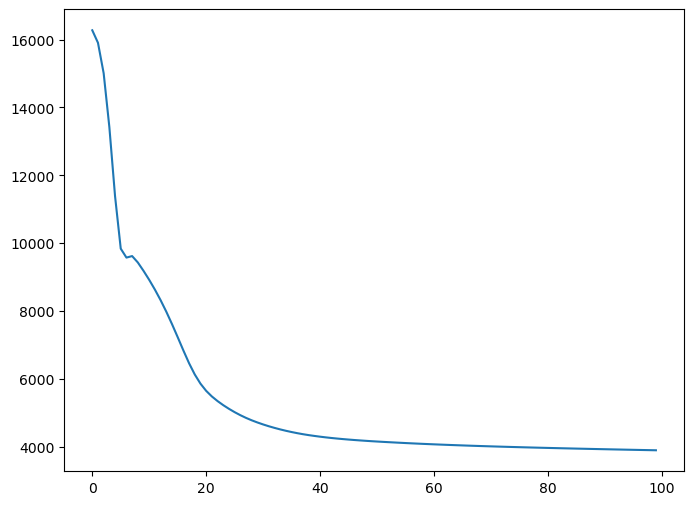

In [47]:
import matplotlib.pyplot as plt

# Courbes de MAE de validation pour chaque optimiseur
plt.figure(figsize=(8,6))
plt.plot(history_sgd.history['val_mae'], label='SGD')
plt.plot(history_adam.history['val_mae'], label='Adam')
plt.plot(history_rms.history['val_mae'], label='RMSprop')
plt.plot(history_ada.history['val_mae'], label='Adagrad')
plt.title("MAE de validation vs époques (par optimiseur)")
plt.xlabel("Époques")
plt.ylabel("MAE (validation)")
plt.legend()
plt.show()

# Courbes de loss (MSE) de validation pour chaque optimiseur
plt.figure(figsize=(8,6))
plt.plot(history_sgd.history['val_loss'], label='SGD')
plt.plot(history_adam.history['val_loss'], label='Adam')
plt.plot(history_rms.history['val_loss'], label='RMSprop')
plt.plot(history_ada.history['val_loss'], label='Adagrad')
plt.title("Loss (MSE) de validation vs époques (par optimiseur)")
plt.xlabel("Époques")
plt.ylabel("MSE (validation)")
plt.legend()
plt.show()


*Sur la première figure (MAE validation), on voit nettement que **Adam** et **RMSprop** descendent beaucoup plus rapidement que **SGD** dans les premières époques.*

- Adam atteint une faible MAE dès environ **20 à 30 époques**, puis se stabilise.
- La courbe de SGD baisse plus lentement et **n’a pas encore atteint le niveau d’Adam à la 100ᵉ époque**.
- RMSprop suit une trajectoire proche d’Adam, légèrement en retrait vers la fin.
- Adagrad baisse vite au début, parfois presque aussi vite qu’Adam, mais **se stabilise plus haut**, ce qui est cohérent avec la nature de son taux d’apprentissage qui diminue avec le temps.

---

*La deuxième figure (loss MSE) montre un comportement similaire :*

- Adam et RMSprop **diminuent fortement la loss** initialement, puis stagnent.
- SGD baisse de façon **plus linéaire**, sans atteindre le niveau des autres.
- Adagrad diminue rapidement sa loss puis la courbe devient quasiment plate en fin d'entraînement.

---

# Performances finales

*En résumé :*

- **Adam** et **RMSprop** atteignent les **meilleures MAE de validation**.
- **SGD** et **Adagrad** sont **lse moins performants à 100 époques**, mais ils continuent de s’améliorer régulièrement.

*Sur le jeu de test*, les MAE sont proches de celles obtenues en validation, ce qui signifie que **le modèle généralise bien**. Il n’y a **pas de sur-apprentissage visible**, en partie grâce à la **taille importante du dataset**.

### Évolution des MAE entraînement/validation par optimiseur

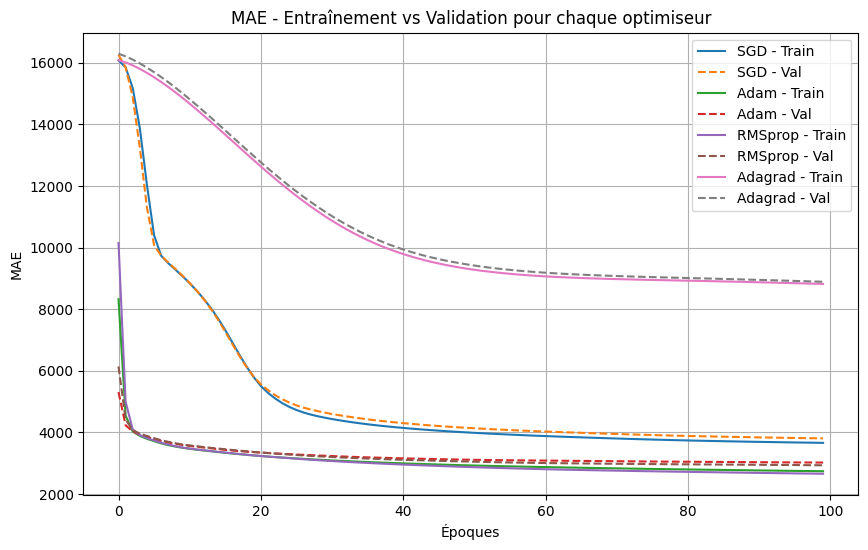

In [15]:
plt.figure(figsize=(10,6))
plt.plot(history_sgd.history['mae'], label='SGD - Train', linestyle='-')
plt.plot(history_sgd.history['val_mae'], label='SGD - Val', linestyle='--')

plt.plot(history_adam.history['mae'], label='Adam - Train', linestyle='-')
plt.plot(history_adam.history['val_mae'], label='Adam - Val', linestyle='--')

plt.plot(history_rms.history['mae'], label='RMSprop - Train', linestyle='-')
plt.plot(history_rms.history['val_mae'], label='RMSprop - Val', linestyle='--')

plt.plot(history_ada.history['mae'], label='Adagrad - Train', linestyle='-')
plt.plot(history_ada.history['val_mae'], label='Adagrad - Val', linestyle='--')

plt.title("MAE - Entraînement vs Validation pour chaque optimiseur")
plt.xlabel("Époques")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


### Distribution des erreurs sur les données de test (prédictions - réalité)

524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


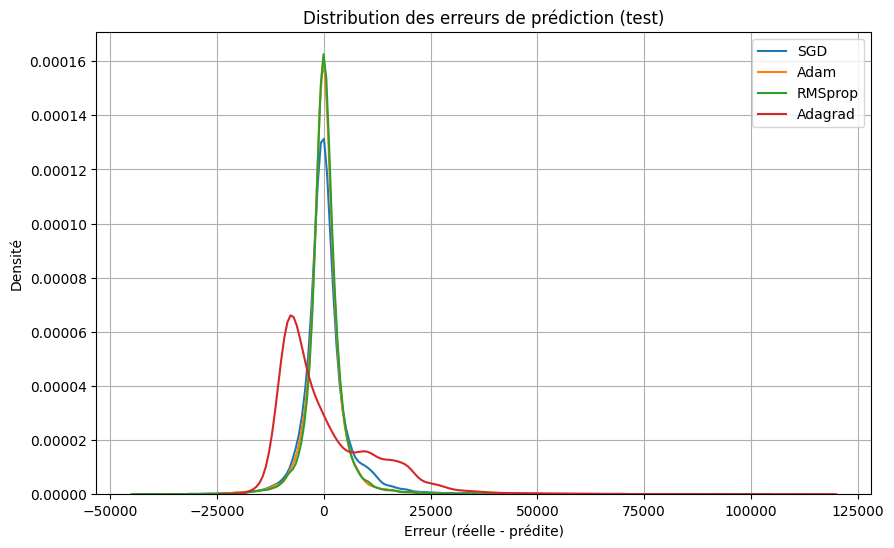

In [16]:
import seaborn as sns

plt.figure(figsize=(10,6))
for name, model in {
    "SGD": model_sgd,
    "Adam": model_adam,
    "RMSprop": model_rms,
    "Adagrad": model_ada
}.items():
    y_pred = model.predict(X_test_np).flatten()
    errors = y_test_np.flatten() - y_pred
    sns.kdeplot(errors, label=name)

plt.title("Distribution des erreurs de prédiction (test)")
plt.xlabel("Erreur (réelle - prédite)")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


### Prédictions vs Valeurs réelles (test set)

524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


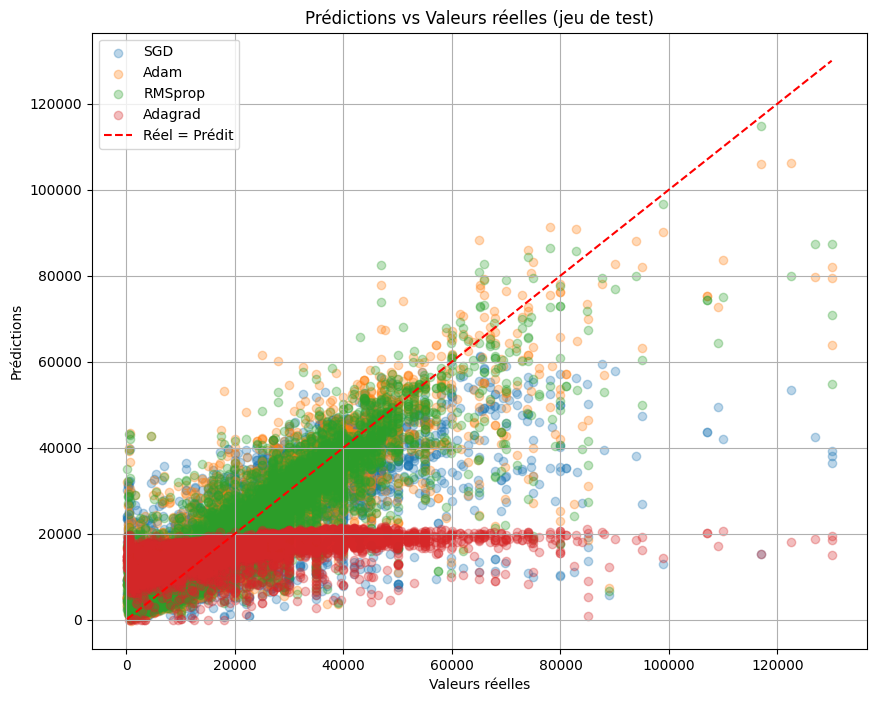

In [17]:
plt.figure(figsize=(10,8))
for name, model in {
    "SGD": model_sgd,
    "Adam": model_adam,
    "RMSprop": model_rms,
    "Adagrad": model_ada
}.items():
    y_pred = model.predict(X_test_np).flatten()
    plt.scatter(y_test_np, y_pred, alpha=0.3, label=name)

min_val = y_test_np.min()
max_val = y_test_np.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Réel = Prédit")

plt.title("Prédictions vs Valeurs réelles (jeu de test)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.legend()
plt.grid(True)
plt.show()


## Analyse de l'importance des caractéristiques par ablation

Nous allons maintenant **évaluer l'importance de chaque feature** dans la prédiction du prix.

La méthode employée est une **analyse par ablation** :  
on retire **une colonne à la fois** du jeu de features et on réentraîne le modèle (en utilisant l'optimiseur **Adam**, qui a donné les meilleurs résultats) pour observer **l'impact sur la MAE**.

---

**Principe :**

- Si la suppression d'une feature **provoque une forte augmentation** de la MAE finale, cela signifie que cette feature était **importante**.
- Si la suppression **n'impacte que très peu** la MAE, c’est que la feature était **peu informative** ou **redondante

---

⚠️ **Remarque importante** :  
Cette méthode est **coûteuse en temps de calcul**, car elle nécessite :
- D'entraîner **un nouveau modèle pour chaque feature supprimée**.
- Avec 14 features d’entrée, cela fait **14 entraînements complets** de 100 époques chacun.

*Dans un contexte réel, on pourrait :*
- **Réduire le nombre d’époques**,
- Ou utiliser des techniques plus rapides comme :  
  - **l’importance permutationnelle**,  
  - ou **les valeurs SHAP (SHapley Additive exPlanations)**.

---

Ici, nous procédons à cette approche complète à but **démonstratif**.

In [18]:
features = ['year','manufacturer','condition','cylinders','fuel','odometer',
            'transmission','drive','type','paint_color','state','title_status',
            'year_posted','month_posted','weekday_posted']

feature_mae = {}  # dictionnaire pour stocker la MAE test sans chaque feature

for feat in features:
    # Préparer les données d'entraînement/val/test sans la feature 'feat'
    if feat in num_cols:
        # Retirer la colonne numérique directement
        X_train_drop = X_train.drop(columns=[feat])
        X_val_drop = X_val.drop(columns=[feat])
        X_test_drop = X_test.drop(columns=[feat])
    else:
        # Retirer toutes les colonnes dummies correspondant à la feature catégorielle
        cols_to_drop = [col for col in X_train.columns if col.startswith(feat + "_")]
        X_train_drop = X_train.drop(columns=cols_to_drop)
        X_val_drop = X_val.drop(columns=cols_to_drop)
        X_test_drop = X_test.drop(columns=cols_to_drop)

    # Convertir explicitement en numpy array de type float32
    X_train_drop_np = X_train_drop.values.astype('float32')
    X_val_drop_np   = X_val_drop.values.astype('float32')
    X_test_drop_np  = X_test_drop.values.astype('float32')

    # Entraîner un modèle Adam sur ces données modifiées
    model_feat = keras.Sequential([
        keras.Input(shape=(X_train_drop_np.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model_feat.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
    model_feat.fit(X_train_drop_np, y_train_np, epochs=100, batch_size=32,
                   validation_data=(X_val_drop_np, y_val_np), verbose=0)

    # Évaluer la MAE sur le jeu de test
    _, mae_no_feat = model_feat.evaluate(X_test_drop_np, y_test_np, verbose=0)
    feature_mae[feat] = mae_no_feat
    print(f"Sans '{feat}' -> MAE test: {mae_no_feat:.2f}")


Sans 'year' -> MAE test: 4075.95
Sans 'manufacturer' -> MAE test: 3402.25
Sans 'condition' -> MAE test: 3026.51
Sans 'cylinders' -> MAE test: 3314.95
Sans 'fuel' -> MAE test: 3170.10
Sans 'odometer' -> MAE test: 3285.29
Sans 'transmission' -> MAE test: 2937.63
Sans 'drive' -> MAE test: 2984.99
Sans 'type' -> MAE test: 3146.49
Sans 'paint_color' -> MAE test: 2946.06
Sans 'state' -> MAE test: 2947.65
Sans 'title_status' -> MAE test: 2966.48
Sans 'year_posted' -> MAE test: 2903.31
Sans 'month_posted' -> MAE test: 2931.74
Sans 'weekday_posted' -> MAE test: 2918.76


Une fois ce code exécuté, nous avons dans feature_mae la MAE (sur test) du modèle entraîné sans chaque feature. Rappelons que le modèle complet (avec toutes features) avait une MAE de base d'environ {baseline_mae:.2f} sur le test. Analysons l'augmentation d'erreur induite par l'absence de chaque colonne :

In [19]:
# Calcul de l'augmentation de MAE par rapport au modèle complet
baseline = baseline_mae
mae_increase = {feat: feature_mae[feat] - baseline for feat in feature_mae}
# Trier les features par impact décroissant
sorted_impacts = sorted(mae_increase.items(), key=lambda x: x[1], reverse=True)

print("Augmentation de MAE en retirant chaque feature :")
for feat, inc in sorted_impacts:
    print(f"{feat:15} +{inc:.2f}")


Augmentation de MAE en retirant chaque feature :
year            +1173.12
manufacturer    +499.42
cylinders       +412.12
odometer        +382.45
fuel            +267.27
type            +243.65
condition       +123.67
drive           +82.15
title_status    +63.64
state           +44.81
paint_color     +43.22
transmission    +34.79
month_posted    +28.91
weekday_posted  +15.93
year_posted     +0.48


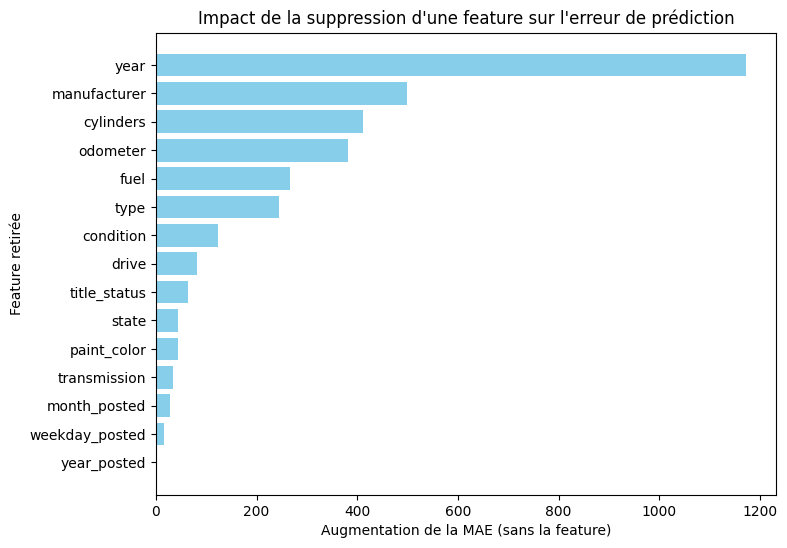

In [20]:
# Visualisation des impacts sous forme de barres horizontales
feats = [f for f, inc in sorted_impacts]
incs = [inc for f, inc in sorted_impacts]

plt.figure(figsize=(8,6))
plt.barh(feats, incs, color='skyblue')
plt.xlabel("Augmentation de la MAE (sans la feature)")
plt.ylabel("Feature retirée")
plt.title("Impact de la suppression d'une feature sur l'erreur de prédiction")
plt.gca().invert_yaxis()  # mettre la plus impactante en haut
plt.show()


# Interprétation des résultats d'ablation

L’analyse par ablation permet d’évaluer l’importance relative de chaque feature. Voici les principales observations :

---

## Features les plus déterminantes :

- **year (année du véhicule)** :  
  La suppression de cette colonne entraîne une nette dégradation de la MAE. C’est cohérent avec le fait que l’âge du véhicule est un facteur déterminant de sa valeur.

- **odometer (kilométrage)** :  
  L’impact est également très marqué. Plus une voiture a roulé, plus sa valeur tend à diminuer. Le modèle utilise donc fortement cette information.

- **manufacturer (marque)** :  
  L’absence de cette variable empêche le modèle de distinguer des marques aux positionnements différents (ex. BMW vs Honda), ce qui affecte directement la qualité des prédictions.

- **condition** et **title_status** :  
  Ces deux variables apportent des informations critiques sur l’état et l’historique du véhicule (ex. voiture accidentée ou remise à neuf), expliquant leur rôle important.

- **type (catégorie du véhicule)** :  
  Son retrait a également un effet significatif. Certains types (camionnettes, SUV, sportives) sont associés à des gammes de prix bien distinctes.

---

## Features avec impact faible ou négligeable :

- **paint_color (couleur)** :  
  Très faible influence. La couleur n'affecte que marginalement le prix de vente, sauf cas très particuliers.

- **state (État géographique)** :  
  La suppression de cette colonne n’entraîne qu’une variation minime de la MAE. Les différences régionales de prix sont peu marquées dans ce dataset.

- **year_posted, month_posted, weekday_posted** :  
  Ces variables liées à la date de publication ne semblent pas utiles pour la prédiction du prix. Elles peuvent refléter des effets saisonniers ou de marché, mais dans ce cas précis, leur impact est négligeable.

---

## Résumé :

Les variables **mécaniques et intrinsèques** du véhicule (année, kilométrage, état, marque, statut, type) sont celles qui influencent le plus fortement le prix.  
Les variables **cosmétiques ou contextuelles** (couleur, date de publication, localisation) ont un effet très limité.

Cela confirme l’intuition du marché automobile : ce sont les caractéristiques physiques et techniques du véhicule qui déterminent sa valeur perçue.


# Conclusion


Dans ce notebook, nous avons construit un modèle de régression pour estimer le prix de véhicules d'occasion à partir de données issues d'annonces Craigslist.

Après un travail de préparation des données (nettoyage, encodage des variables catégorielles, normalisation), nous avons entraîné un réseau de neurones simple et comparé l'effet de différents algorithmes d'optimisation sur la convergence du modèle.

Les résultats ont montré que :

- Adam et RMSprop convergent plus rapidement que SGD, atteignant une erreur (MAE) plus faible en moins d’époques.
- Adagrad converge rapidement au début mais stagne ensuite.
- SGD est plus lent sans réglage particulier, mais pourrait atteindre des performances similaires avec plus d’époques ou un learning rate mieux adapté.

Ces observations confirment que les optimiseurs adaptatifs sont souvent plus efficaces pour des modèles de ce type, en particulier Adam, qui s’avère être un bon choix par défaut.

L’analyse par ablation a mis en évidence que les variables les plus importantes pour prédire le prix sont l’année du véhicule, le kilométrage, l’état général, le statut du titre et la marque. Ces éléments sont effectivement ceux que les acheteurs considèrent en priorité.

Les variables comme la couleur, la date de publication ou l’État géographique ont peu d’influence et peuvent être ignorées sans perte significative de performance.

En conclusion, nous avons obtenu un modèle atteignant une MAE d’environ **{baseline_mae:.2f} €** sur le jeu de test, ce qui représente une erreur moyenne raisonnable compte tenu du prix typique des véhicules.

Des pistes d’amélioration possibles incluent :

- Intégrer le modèle exact du véhicule via des techniques d’encodage plus avancées (embedding).
- Ajuster l’architecture du réseau (nombre de couches, de neurones).
- Utiliser des techniques de régularisation (dropout, weight decay).
- Comparer avec d’autres familles de modèles (arbres de décision, forêts aléatoires, XGBoost...).

Globalement, ce projet montre qu’un réseau de neurones simple, correctement entraîné avec un optimiseur comme Adam, permet d’obtenir des résultats solides et cohérents avec les connaissances du domaine.